In [1]:
%%time
from sklearn.datasets import load_files
import numpy as np
import re

# 整理 aclImdb 目录下的数据
print("整理数据中...")

# 清洗文本
def wash_text(text):
    text = text.lower().replace(u'\x85', '').replace(u'\n', '').replace(u'<br/>', '').replace('<br />', '')
    # 把标点符号算作一个词
    text = re.sub(r"([\.\",\(\)!\?;:])", " \\1 ", text)
    return text

# 使用 sklearn 的 load_files 导入 category/data.txt 格式的目录, 并且去掉 unsup 分类
reviews_train = load_files("data/aclImdb/train/")
unsup_index = reviews_train.target_names.index('unsup')
text_train = []
y_train = []
text_unsup = []
for t, y in zip(reviews_train.data, reviews_train.target):
    if y != unsup_index:
        text_train.append(wash_text(t.decode('utf-8')))
        y_train.append(y)
    else:
        text_unsup.append(wash_text(t.decode('utf-8')))

print("训练用评论: {}".format(len(text_train)))
print("训练用评论(按pos/neg分类): {}".format(np.bincount(y_train)))

print("非监督(聚类)用评论: {}".format(len(text_unsup)))

reviews_test = load_files("data/aclImdb/test/")
text_test = [wash_text(t.decode('utf-8')) for t in reviews_test.data]
y_test = reviews_test.target
        
print("测试用评论: {}".format(len(text_test)))
print("测试用评论(按pos/neg分类): {}".format(np.bincount(y_test)))

整理数据中...
训练用评论: 25000
训练用评论(按pos/neg分类): [12500 12500]
非监督(聚类)用评论: 50000
测试用评论: 25000
测试用评论(按pos/neg分类): [12500 12500]
CPU times: user 6.37 s, sys: 3.67 s, total: 10 s
Wall time: 18.4 s


In [21]:
reviews_train.target_names

['neg', 'pos', 'unsup']

In [2]:
from gensim.models.doc2vec import TaggedDocument
docs_train = []
for no, (text, y) in enumerate(zip(text_train, y_train)):
    doc = TaggedDocument(text.split(), [000000 + no])
    doc.y = y
    docs_train.append(doc)
                
docs_test = []
for no, (text, y) in enumerate(zip(text_test,y_test)):
    doc = TaggedDocument(text.split(), [100000 + no])
    doc.y = y
    docs_test.append(doc)
    
docs_unsup = []
for no, text in enumerate(text_unsup):
    docs_unsup.append(TaggedDocument(text.split(), [200000 + no]))

In [3]:
docs_train[1233].y

1

In [4]:
%%time
import gensim
from gensim.models import Doc2Vec
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
import multiprocessing

from itertools import chain

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "gensim 不是多核版本!!"

# 建立几个 Doc2Vec 模型 (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb)
# 此处可以修改超参如 vector_size
pv_dbow_plain = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample=0, 
            epochs=20, workers=cores)
pv_dmm = Doc2Vec(dm=1, vector_size=100, window=10, negative=5, hs=0, min_count=2, sample=0, 
            epochs=20, workers=cores, alpha=0.05, comment='alpha=0.05')
pv_dmc = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=5, negative=5, hs=0, min_count=2, sample=0, 
            epochs=20, workers=cores)

# 初始化模型, 在其内建立词汇表
# 这里也可以用全部数据(包括测试集)吗? 会不会造成数据泄露?
pv_dbow_plain.build_vocab(chain(docs_train, docs_unsup))
pv_dmm.build_vocab(chain(docs_train, docs_unsup))
pv_dmc.build_vocab(chain(docs_train, docs_unsup))

# Doc2Vec 的论文提及将 DBOW 和 DM 方法的模型连接起来会改善效果
dbow_dmm = ConcatenatedDoc2Vec([pv_dbow_plain, pv_dmm])
dbow_dmc = ConcatenatedDoc2Vec([pv_dbow_plain, pv_dmc])

CPU times: user 14.6 s, sys: 74 ms, total: 14.7 s
Wall time: 14.7 s


In [5]:
current_model = pv_dbow_plain

In [6]:
current_model.init_sims(True)

In [7]:
%%time
# 打散所有文档, 然后开始训练
from random import shuffle
docs_train_and_unsup_shuffled = list(chain(docs_train, docs_unsup))
shuffle(docs_train_and_unsup_shuffled)

current_model.train(docs_train_and_unsup_shuffled,
                    total_examples=len(docs_train_and_unsup_shuffled),
                    epochs=pv_dbow_plain.epochs)
# 待补充: 把剩下四个模型也训练了

CPU times: user 8min 32s, sys: 4.12 s, total: 8min 37s
Wall time: 1min 54s


In [8]:
# docvecs 用 tags 作为下标, 所以有用的下标只有 [0-24999](train) 和 [200000-249999](unsup)
print(np.around(current_model.docvecs[249999],2))
print(np.around(current_model.docvecs[250000],2))

[-0.26 -0.24  0.05 -0.15 -0.22 -0.63  0.22  0.48 -0.26 -0.09  0.38 -0.37
 -0.31 -0.06 -0.06  0.22  0.05  0.1   0.04  0.5  -0.32 -0.15  0.67 -0.5
  0.14  0.11 -0.16 -0.39 -0.01 -0.39 -0.18  0.5   0.2   0.15  0.35  0.04
  0.03 -0.14 -0.52  0.12 -0.29  0.32 -0.14 -0.37 -0.   -0.12 -0.03 -0.12
  0.49 -0.31  0.36  0.11  0.24  0.67  0.82 -0.13  0.    0.14  0.99 -0.09
  0.17 -0.04  0.15  0.22  0.62 -0.22  0.64  0.71 -0.05  0.18  0.3  -0.54
  0.13 -0.44  0.19  0.04  0.06  0.29  0.08 -0.02 -0.   -0.36  0.25 -0.06
  0.71 -0.31  0.41 -0.04 -0.37 -0.56  0.1  -0.19 -0.31 -0.07 -0.04  0.06
 -0.39 -0.24 -0.32  0.49]


KeyError: "tag '250000' not seen in training corpus/invalid"

In [9]:
# 来看看这个模型靠不靠谱
demon_no = 1233
demon_doc = filter(lambda x: x.tags==[demon_no], docs_train).__next__()
demon_y = demon_doc.y
print("Doc %d: (%d)" % (demon_no, demon_y), ' '.join(demon_doc.words))
print()
print("The vector of this doc:", np.around(current_model.docvecs[demon_no], 2))
print()
demon_new = "a clever script from the late sebastian japrisot and smart performances from the two male leads - alain delon and charles bronson ( or should it be the other way around ) result in an engaging and entertaining thriller . add to the above the competent direction from veteran jean herman and a sparse but effective score by francois de roubaix , it becomes easy why this film has an odd timeless quality . this is a buddy buddy or bonding story with two loners , both disillusioned and world weary , returning , presumably from algiers . like the other colonial powers of this time ( post ww ii leading into the 60s ) , france had struggled to keep up appearances overseas . losing algiers was a bitter blow . adieu l'ami ( the original title ) chronicles the actions of our two ( anti ) heroes as they struggle to make a go of it , after their discharge . one thing happens after another , and the viewer really has to pay attention , because japrisot is lean and economical with his script : if it is there , then there must be a reason . suffice to say , these two men battle it out , physically and psychologically , one long weekend . their motivation is quite different , their goals are different - their survival depends entirely on each other . that alain delon and charles bronson are outwardly so different - the former , arguably a pretty boy , and the latter an ugly thug , adds to the chemistry . that quest makes for a great story , which in turn , makes for a great film . lest i forget there are women in this film , and true to the japrisot method , they too are memorable , though not nearly as fleshed out ; to say much more would be to spoil one's delight in discovering their true nature . farewell , friend has been released in the uk ; an anamorphic image , 16 . 9 enhanced ; in english only ( not even subtitles for the hard of hearing ) ; a running time of 110 minutes ; mono soundtrack but the de roubaix music has lots of punch ! highly recommended ."
demon_new = demon_new.split()
print("A new doc: ", ' '.join(demon_new))
print()
print("The vector of this new doc:", np.around(current_model.infer_vector(demon_new), 2))
print()
print("Much alike! aren't they?")

Doc 1233: (1) a clever script from the late sebastian japrisot and smart performances from the two male leads - alain delon and charles bronson ( or should it be the other way around ) result in an engaging and entertaining thriller . add to the above the competent direction from veteran jean herman and a sparse but effective score by francois de roubaix , it becomes easy why this film has an odd timeless quality . this is a buddy buddy or bonding story with two loners , both disillusioned and world weary , returning , presumably from algiers . like the other colonial powers of this time ( post ww ii leading into the 60s ) , france had struggled to keep up appearances overseas . losing algiers was a bitter blow . adieu l'ami ( the original title ) chronicles the actions of our two ( anti ) heroes as they struggle to make a go of it , after their discharge . one thing happens after another , and the viewer really has to pay attention , because japrisot is lean and economical with his sc

In [10]:
%%time
# 然后把所有的 train 文档整理为可供 Logistic Regression 学习器学习的张量
from tqdm import tqdm_notebook
order_map = np.arange(len(docs_train))
np.random.shuffle(order_map)

sample_num = len(docs_train)
features_train_shuffled = np.ndarray((sample_num, current_model.vector_size))

features_num = current_model.vector_size

def generate_shuffled_docs():
    for index in order_map:
        yield docs_train[index]

for i, doc in tqdm_notebook(enumerate(generate_shuffled_docs()), total=sample_num):
    features_train_shuffled[i,:] = current_model.docvecs[doc.tags[0]]
    
y_train_shuffled = np.asarray(y_train)[order_map]


CPU times: user 76 ms, sys: 110 µs, total: 76.1 ms
Wall time: 83.9 ms


In [11]:
import time
# 开始 Logistic 部分 (纯 Python)
# 输入: features_train
minibatch_size = 50
def get_minibatch(x_train, y_train, minibatch_size):
    for i in range(0, sample_num, minibatch_size):
        yield x_train[i:i+minibatch_size], y_train[i:i+minibatch_size]

def sigmoid(x):
    return 1. / (1 + np.exp(-x))
        
learning_rate = 0.01

theta = np.random.randn(features_num)

for epoch in range(30):
    total_abs_loss = 0
    total_loss = 0
    for i, (x_batch, y_batch) in enumerate(get_minibatch(features_train_shuffled, y_train_shuffled, minibatch_size)):
        outputs = sigmoid(np.dot(x_batch, theta))
        individual_cel = - y_batch * np.log(outputs) - (1 - y_batch) * np.log(1 - outputs)
        cross_entropy_loss = individual_cel.sum()
        
        total_abs_loss += np.abs(outputs - y_batch).sum()
        total_loss += cross_entropy_loss
        
        partial_common = (outputs - y_batch)
        delta_theta = (partial_common[:, np.newaxis] * x_batch).sum(axis=0)
        theta -= learning_rate * delta_theta
        
    avg_loss = total_loss
    print("Epoch %d : Avg Loss %f" % (epoch, avg_loss))

Epoch 0 : Avg Loss 10537.789932
Epoch 1 : Avg Loss 6713.383619
Epoch 2 : Avg Loss 6683.776234
Epoch 3 : Avg Loss 6682.213666
Epoch 4 : Avg Loss 6682.108047
Epoch 5 : Avg Loss 6682.106338
Epoch 6 : Avg Loss 6682.109085
Epoch 7 : Avg Loss 6682.110340
Epoch 8 : Avg Loss 6682.110789
Epoch 9 : Avg Loss 6682.110942
Epoch 10 : Avg Loss 6682.110993
Epoch 11 : Avg Loss 6682.111010
Epoch 12 : Avg Loss 6682.111016
Epoch 13 : Avg Loss 6682.111018
Epoch 14 : Avg Loss 6682.111019
Epoch 15 : Avg Loss 6682.111019
Epoch 16 : Avg Loss 6682.111019
Epoch 17 : Avg Loss 6682.111019
Epoch 18 : Avg Loss 6682.111019
Epoch 19 : Avg Loss 6682.111019
Epoch 20 : Avg Loss 6682.111019
Epoch 21 : Avg Loss 6682.111019
Epoch 22 : Avg Loss 6682.111019
Epoch 23 : Avg Loss 6682.111019
Epoch 24 : Avg Loss 6682.111019
Epoch 25 : Avg Loss 6682.111019
Epoch 26 : Avg Loss 6682.111019
Epoch 27 : Avg Loss 6682.111019
Epoch 28 : Avg Loss 6682.111019
Epoch 29 : Avg Loss 6682.111019


In [12]:
(abs(sigmoid(np.dot(features_train_shuffled, theta)) - y_train_shuffled)).sum() / sample_num

0.15807681076770422

In [13]:
# sklearn 的 LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver='sag'), param_grid, cv=5)
grid.fit(features_train_shuffled, y_train_shuffled)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

lr = grid.best_estimator_

Best cross-validation score: 0.89
Best parameters:  {'C': 10}
Best estimator:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)


In [14]:
def apply_logistic_purelr(x):
    return np.around(sigmoid(np.dot(x, theta))).astype(np.int)

def apply_logistic_sklearnlr(x):
    return lr.predict(x)

In [15]:
%%time
# 生成测试数据的 Paragraph Vector
features_test = np.ndarray((len(docs_test), current_model.vector_size))
test_num = len(docs_test)

for i, doc in tqdm_notebook(enumerate(docs_test), total=len(docs_test)):
    features_test[i,:] = current_model.infer_vector(doc.words)
    
y_test = np.asarray(y_test)


CPU times: user 1min 55s, sys: 67 ms, total: 1min 55s
Wall time: 1min 55s


In [16]:
print(apply_logistic_purelr(features_test[0:20]))
print(apply_logistic_sklearnlr(features_test[0:20]))
print(y_test[0:20])

[1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1]
[1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1]
[1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1]


In [17]:
def test_score_purelr():
    return (apply_logistic_purelr(features_test) == y_test).sum() / features_test.shape[0]

def test_score_sklearnlr():
    return lr.score(features_test, y_test)

print(test_score_purelr())
print(test_score_sklearnlr())

0.89164
0.89196


In [18]:
def train_score_purelr():
    return (apply_logistic_purelr(features_train_shuffled) == y_train_shuffled).sum() / features_train_shuffled.shape[0]

def train_score_sklearnlr():
    return lr.score(features_train_shuffled, y_train_shuffled)

print(train_score_purelr())
print(train_score_sklearnlr())

0.89216
0.89348


In [39]:
import matplotlib.pyplot as plt
from importlib import reload
reload(plt)
%matplotlib inline

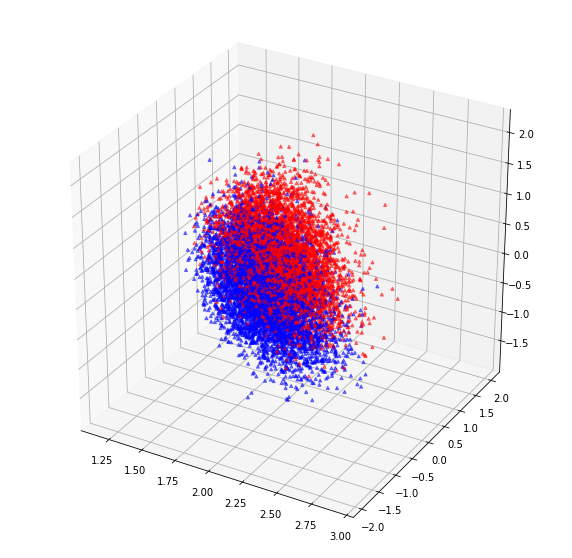

In [40]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from mpl_toolkits.mplot3d import Axes3D, axes3d

svd = TruncatedSVD(n_components=3)
pca = PCA(n_components=3)

sample_features = features_test[np.random.choice(features_test.shape[0], 10000, replace=False), :]

svd.fit(features_test)
reduced_x = svd.transform(sample_features)
pos_x,pos_y,pos_z = [],[],[]
neg_x,neg_y,neg_z = [],[],[]

y_plot_pre = apply_logistic_purelr(sample_features)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_x[:,0],reduced_x[:,1],reduced_x[:,2],c=list(map(lambda x:['b','r'][x], y_plot_pre)),marker='^',s=10,alpha=0.5)

plt.show()

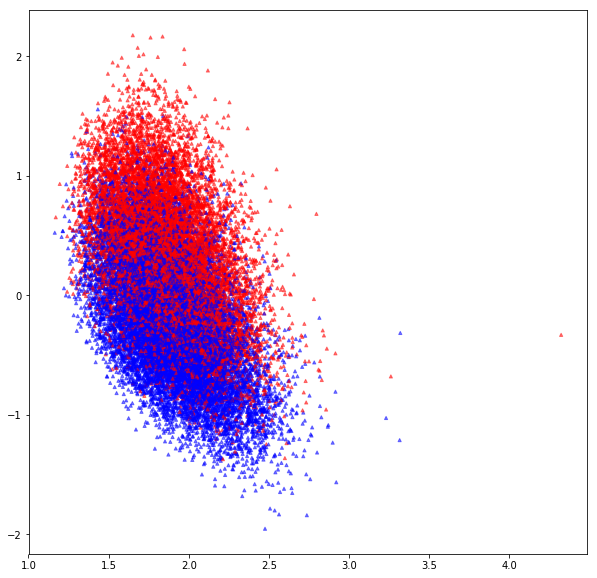

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from mpl_toolkits.mplot3d import Axes3D, axes3d

svd = TruncatedSVD(n_components=2)
pca = PCA(n_components=2)

sample_features = features_test[np.random.choice(features_test.shape[0], 25000, replace=False), :]

svd.fit(features_test)
reduced_x = svd.transform(sample_features)
pos_x,pos_y,pos_z = [],[],[]
neg_x,neg_y,neg_z = [],[],[]

y_plot_pre = apply_logistic_purelr(sample_features)

for i in range(len(y_plot_pre)):
    if y_plot_pre[i] == 0:
        neg_x.append(reduced_x[i][0])
        neg_y.append(reduced_x[i][1])
    else:
        pos_x.append(reduced_x[i][0])
        pos_y.append(reduced_x[i][1])

fig = plt.figure(figsize=(10,10))

plt.scatter(reduced_x[:,0],reduced_x[:,1],c=list(map(lambda x:['b','r'][x], y_plot_pre)),marker='^',s=10,alpha=0.5)

plt.show()

<Figure size 432x288 with 0 Axes>

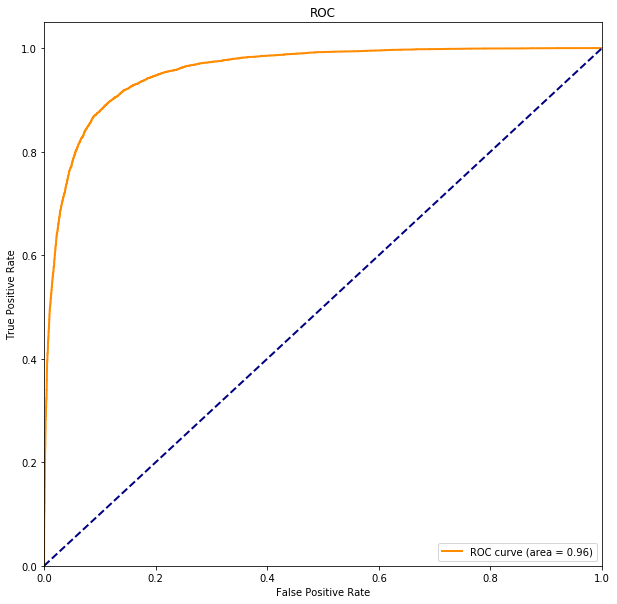

In [48]:
from sklearn.metrics import roc_curve, auc

y_plot_pre = grid.best_estimator_.decision_function(features_test)

fpr, tpr, threshold = roc_curve(y_test, y_plot_pre) ###计算真正率和假正率
roc_auc = auc(fpr, tpr) ###计算auc的值
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

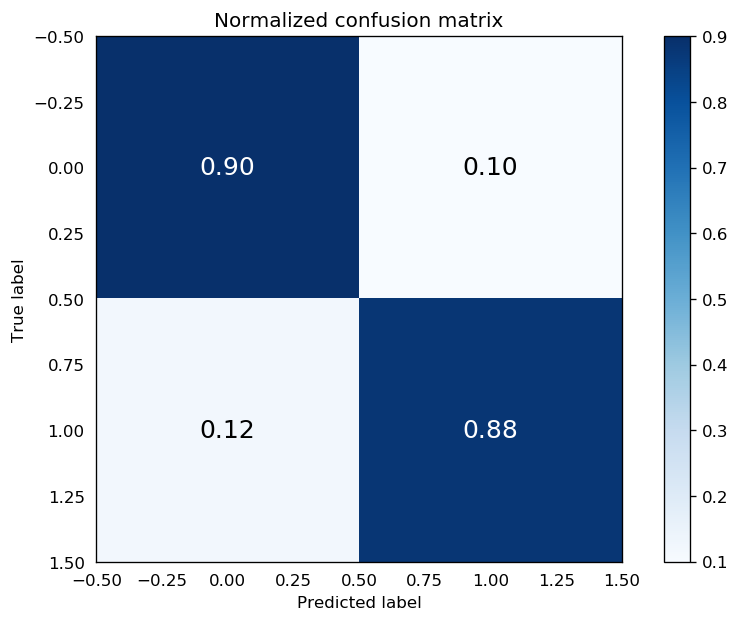

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_plot_pre = lr.predict(features_test)
cm = confusion_matrix(y_test, y_plot_pre)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,6), dpi=120)
ind_array = np.arange(2)
x, y = np.meshgrid(ind_array, ind_array)
 
for x_val, y_val in zip(x.flatten(), y.flatten()):
    thresh = cm_normalized.max()/2
    c = cm_normalized[y_val][x_val]
    if (c > 0.01):
        plt.text(x_val, y_val, "%0.2f" %(c,), color='white' if cm_normalized[x_val, y_val] > thresh else "black", fontsize=15, va='center', ha='center')
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)
 
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
#show confusion matrix
plt.show()

In [41]:
# Demonstration
my_doc = TaggedDocument("10 10".split(), ['my'])
my_vector = current_model.infer_vector(my_doc.words)
print(reviews_train.target_names[apply_logistic_purelr(my_vector)])

pos
